<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/canadian_cousins_research_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>Cousin Cities</center></h1>

> A cluster analysis of Canadian municipalities by climate, demographics and urban patterns



in case it's useful: reference 'how to launch a dash app' in colab: https://stackoverflow.com/questions/53622518/launch-a-dash-app-in-a-google-colab-notebook

as well as here https://community.plotly.com/t/colab-and-easy-dash-sample/26799

and then quick example with iris dataset: https://plotly.com/python/line-and-scatter/

some inspiration:

https://groundrush.pythonanywhere.com/


## 0. Preamble (installs)

In [2]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

# Install plotlyExpress
!pip install plotly_express

!pip install geopandas


Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,614 kB/s)
Selecting previously unselected

## 1. Import libraries and data sets



### 1.1 Import libraries

In [3]:
import pandas as pd
import numpy as np

import os
from google.colab import drive

import geopandas as gpd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf

from IPython.display import HTML #(then use HTML(fig.to_html()))
#import contextily as ctx

import seaborn as sns

from matplotlib import pyplot as plt

import plotly_express as px
 
import scipy.cluster.hierarchy as shc 
from sklearn.cluster import AgglomerativeClustering

### 1.2 Mount google drive

In [4]:
# mount google drive
drive.mount('/content/gdrive/')

root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'data_viz_club/'


Mounted at /content/gdrive/


### 1.3 Go get the data sets!

#### Data Provenance
Public Datasets Used:

Statistics Canada 2016 Census Data portal
Environment and Climate Change Canada Historic Weather 

Expanded Project Datasets (for inclusion later on):
 

In [5]:
# Read in data

# Read in CSD Census Profiles
# From Statistics Canada 
filename = base_dir + 'raw_data_files/98-401-X2016042_English_CSV_data.csv'
df_census = pd.read_csv(filename)


# Read Pre-processed weather data--> Geopandas
# This file was processed separately. It contains the shapes of CSDs and the HDDS and CDDS for 2018 of nearest weather station 
filename = base_dir + 'raw_data_files/csd_with_nearest_weatherStation.pkl'
gdf_weather = pd.read_pickle(filename)


# Read in transportation data (includes population)
# From Statistics Canada
filename = base_dir + 'raw_data_files/23100286.csv'
df_trnsp = pd.read_csv(filename)

# Read in Remoteness Index
# From Statistics Canada
filename = base_dir + 'raw_data_files/17100143.csv'
df_remote = pd.read_csv(filename)


# Future data sets:

# Read census commuting and occupation 
# from https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dt-td/Lp-eng.cfm?LANG=E&APATH=7&DETAIL=0&DIM=0&FL=C&FREE=0&GC=0&GID=0&GK=0&GRP=1&PID=0&PRID=10&PTYPE=109445&S=0&SHOWALL=0&SUB=0&Temporal=2016,2017&THEME=0&VID=0&VNAMEE=Commuting%20duration%20%286%29&VNAMEF=Dur%C3%A9e%20du%20trajet%20domicile%2Dlieu%20de%20travail%20%286%29
 
# Read in NAICS data? 
# e.g., percentage in ag or ind...

# Read in MEED data! 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.



## Clean and organize

#### start with census data: limiting factor on which CSDs have 'complete' data


In [6]:
df_census.query('GEO_LEVEL == 3').GEO_NAME.nunique() # 942 Census Subdivisions in this set
df_census.query('GEO_NAME == "Toronto"') # Check whether level 3 CSDs include the level 2s...i.e., is Toronto in level 3 and 2? or just 2? (Answer: it's in both)

df_census.query('GEO_LEVEL == 3')['DIM: Profile of Census Subdivisions (2247)'].nunique() # 1135 features

#To see all:
#with np.printoptions(threshold=np.inf):
 #   print(df_census.query('GEO_LEVEL == 3')['DIM: Profile of Census Subdivisions (2247)'].unique())

1135

In [7]:
df_census.query('GEO_LEVEL == 3').head()

,CENSUS_YEAR,GEO_CODE (POR),GEO_LEVEL,GEO_NAME,GNR,GNR_LF,DATA_QUALITY_FLAG,CSD_TYPE_NAME,ALT_GEO_CODE,DIM: Profile of Census Subdivisions (2247),Member ID: Profile of Census Subdivisions (2247),Notes: Profile of Census Subdivisions (2247),Dim: Sex (3): Member ID: [1]: Total - Sex,Dim: Sex (3): Member ID: [2]: Male,Dim: Sex (3): Member ID: [3]: Female
2247,2016,1001485,3,Conception Bay South,2.5,3.9,0,T,10011001485,"Population, 2016",1,1.0,26199,...,...
2248,2016,1001485,3,Conception Bay South,2.5,3.9,0,T,10011001485,"Population, 2011",2,2.0,24848,...,...
2249,2016,1001485,3,Conception Bay South,2.5,3.9,0,T,10011001485,"Population percentage change, 2011 to 2016",3,NaN,5.4,...,...
2250,2016,1001485,3,Conception Bay South,2.5,3.9,0,T,10011001485,Total private dwellings,4,3.0,10553,...,...
2251,2016,1001485,3,Conception Bay South,2.5,3.9,0,T,10011001485,Private dwellings occupied by usual residents,5,4.0,9934,...,...


In [8]:
# Get all CSDs (GEO_LEVEL 3) and rename columns
df_census_0 = df_census.query(
    'GEO_LEVEL == 3')[[
                        'GEO_NAME',
                        'GEO_CODE (POR)',
                        'GNR_LF',
                        'DIM: Profile of Census Subdivisions (2247)',
                        'Dim: Sex (3): Member ID: [1]: Total - Sex']].rename(columns={
                              'GEO_NAME' : 'geo_name',
                              'GEO_CODE (POR)' : 'geo_code',
                              'GNR_LF':'nonResponse_rt',
                              'DIM: Profile of Census Subdivisions (2247)':'feature',
                              'Dim: Sex (3): Member ID: [1]: Total - Sex':'value'})  

# Trim the 1135 features down to those that might be of interest...
ls_of_interest = ['Population, 2016',
                  'Population percentage change, 2011 to 2016',
                   'Population density per square kilometre',
                   'Median age of the population',
                   'Total - Occupied private dwellings by structural type of dwelling - 100% data',
                   'Single-detached house',
                   'Apartment in a building that has five or more storeys',
                   'Average household size',
                   'Official language minority (percentage)',
                   'Total - Language spoken most often at home for the total population excluding institutional residents - 100% data',
                   'Non-official languages',
                   'Number of total income recipients aged 15 years and over in private households - 100% data',
                   'Median total income in 2015 among recipients ($)',
                   'Number of government transfers recipients aged 15 years and over in private households - 100% data',
                   'Total - Generation status for the population in private households - 25% sample data',
                   'First generation',
                   'Second generation',
                   'Total - Aboriginal identity for the population in private households - 25% sample data',
                   'Aboriginal identity',
                   'Total - Private households by tenure - 25% sample data',
                   'Owner',
                   'Renter',
                   'Band housing',
                   'Total - Occupied private dwellings by period of construction - 25% sample data',
                   '1960 or before',
                   '2011 to 2016',
                   'Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data',
                   'No certificate, diploma or degree',
                   'Secondary (high) school diploma or equivalency certificate',
                   'University certificate, diploma or degree at bachelor level or above',
                   'Degree in medicine, dentistry, veterinary medicine or optometry',
                   'Earned doctorate',
                   'Postsecondary certificate, diploma or degree',
                   'Same as province or territory of residence', #location of study
                   'Location of study outside Canada',
                   'Total - Population aged 15 years and over by Labour force status - 25% sample data',
                   'Participation rate',
                   'Unemployment rate',
                   'All occupations',
                   '0 Management occupations',
                   '1 Business, finance and administration occupations',
                   '2 Natural and applied sciences and related occupations',
                   '3 Health occupations',
                   '4 Occupations in education, law and social, community and government services',
                   '5 Occupations in art, culture, recreation and sport',
                   '6 Sales and service occupations',
                   '7 Trades, transport and equipment operators and related occupations',
                   '8 Natural resources, agriculture and related production occupations',
                   '9 Occupations in manufacturing and utilities',
                   'Total - Place of work status for the employed labour force aged 15 years and over in private households - 25% sample data',
                   'Worked at home',
                   'Worked outside Canada',
                   'No fixed workplace address',
                   'Worked at usual place',
                   'Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data',
                   'Car, truck, van - as a driver',
                   'Car, truck, van - as a passenger',
                   'Public transit',
                   'Walked',
                   'Bicycle',
                   'Other method',
                   'Total - Commuting duration for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data',
                   'Less than 15 minutes',
                   '60 minutes and over']

df_census_1 = df_census_0[df_census_0['feature'].isin(ls_of_interest)]

In [9]:
#df_census_1.info()

# need to convert value column to numeric types
df_census_1['value'] = df_census_1['value'].apply(pd.to_numeric, errors='coerce')

# pivot so that features become separate columns for each CSD (one row)
df_census_1a = df_census_1.pivot_table(index=['geo_name','geo_code','nonResponse_rt'], columns='feature', values='value').reset_index()

#df_census_2.shape # 907 rows, 67 columns


In [10]:
# Use features to create percentages and/or refine values to use
df_census_2a = df_census_1a.copy()
df_census_3 = pd.DataFrame()

df_census_3['geo_name'] = df_census_2a['geo_name']
df_census_3['geo_code'] = df_census_2a['geo_code']

# Demographics (age, education)
df_census_3['pop_tot'] = df_census_2a['Population, 2016']
df_census_3['pop_density'] = df_census_2a['Population density per square kilometre']
df_census_3['pop_change'] = df_census_2a['Population percentage change, 2011 to 2016']
df_census_3['pop_medAge'] = df_census_2a['Median age of the population']
df_census_3['school_none'] = df_census_2a['No certificate, diploma or degree']/df_census_2a['Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'] 
df_census_3['school_uni'] = df_census_2a['University certificate, diploma or degree at bachelor level or above']/df_census_2a['Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'] 

# Jobs (Sectors and unemployment and pay)
df_census_3['work_unempRate'] = df_census_2a['Unemployment rate'] 
df_census_3['work_agr'] = df_census_2a['8 Natural resources, agriculture and related production occupations']/df_census_2a['All occupations']
df_census_3['work_arts'] = df_census_2a['5 Occupations in art, culture, recreation and sport']/df_census_2a['All occupations']
df_census_3['work_biz'] = df_census_2a['1 Business, finance and administration occupations']/df_census_2a['All occupations']


# Urbanism (density, age)
df_census_3['trnst_active'] = (df_census_2a['Walked']+df_census_2a['Bicycle']) /df_census_2a['Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data']

df_census_3['trnst_car'] = (df_census_2a['Car, truck, van - as a driver']+df_census_2a['Car, truck, van - as a passenger']) /df_census_2a['Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data']

df_census_3['trnst_15minutes'] = df_census_2a['Less than 15 minutes']/df_census_2a['Total - Commuting duration for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data'] 

df_census_3['bldgs_house'] = df_census_2a['Single-detached house']/df_census_2a['Total - Occupied private dwellings by structural type of dwelling - 100% data']
df_census_3['bldgs_aprtmnt'] = df_census_2a['Apartment in a building that has five or more storeys']/df_census_2a['Total - Occupied private dwellings by structural type of dwelling - 100% data']

# Culture (language, migration)
df_census_3['pop_1stGenImm'] = df_census_2a['First generation']/df_census_2a['Total - Generation status for the population in private households - 25% sample data']
df_census_3['lang_noEngFr'] = df_census_2a['Non-official languages']/df_census_2a['Total - Language spoken most often at home for the total population excluding institutional residents - 100% data']


In [11]:
# Which rows are missing data?
null_data = df_census_3[df_census_3.isnull().any(axis=1)]

# Drop these going forward...
df_census_4 = df_census_3[~df_census_3.isnull().any(axis=1)] # 903 CSDs complete census info

#### Pare down weather *data*


In [67]:
# get rid of non-needed columns and convert ID column to numeric
df_weather = gdf_weather[['CSDUID','geometry_CSD','HDD_tot','CDD_tot']]
df_weather['CSDUID'] = pd.to_numeric(df_weather['CSDUID'])
    
 
# Merge census and weather
df_combo = df_census_4.merge(df_weather,
                              left_on = 'geo_code', 
                              right_on = 'CSDUID',
                              how='left').drop(columns=['CSDUID'])            

#### Remoteness

In [13]:
# Trip to relavant columns
df_remote_1 = df_remote[['GEO','DGUID','Characteristics','VALUE']].query('Characteristics == "Index of remoteness"').rename(columns={'VALUE':'rmt_indx'})

# DGUID has extra characters...need to trim to be able to use as a merging key
df_remote_1['geo_ID'] = df_remote_1['DGUID'].str[-7:]
df_remote_1['geo_ID'] = pd.to_numeric(df_remote_1['geo_ID'])

In [14]:
df_combo_2 = df_combo.merge(df_remote_1[['GEO','geo_ID','rmt_indx']],
                              left_on = 'geo_code', 
                              right_on = 'geo_ID',
                              how='left').drop(columns=['geo_ID'])

# Move last columns (with complete place name and remote index) to first position, and drop duplicate place name
cols = list(df_combo_2.columns)
cols = [cols[-2]] + [cols[-1]]+ cols[:-2]
df_combo_3 = df_combo_2[cols].drop(columns=['geo_name']) 

df_combo_3

,GEO,rmt_indx,geo_code,pop_tot,pop_density,pop_change,pop_medAge,school_none,school_uni,work_unempRate,work_agr,work_arts,work_biz,trnst_active,trnst_car,trnst_15minutes,bldgs_house,bldgs_aprtmnt,pop_1stGenImm,lang_noEngFr,HDD_tot,CDD_tot
0,"Abbotsford (CY), British Columbia",0.1315,5909052,141397.0,376.5,5.9,39.0,0.155730,0.148359,6.6,0.058317,0.020242,0.134949,0.040196,0.924355,0.353933,0.398348,0.020392,0.297210,0.235351,2680.813547,163.637931
1,"Aberdeen (T), Saskatchewan",0.2595,4715019,622.0,318.8,3.8,33.9,0.173913,0.097826,8.3,0.033898,0.033898,0.237288,0.092593,0.907407,0.185185,0.934783,0.000000,0.042735,0.028226,6052.908161,137.855172
2,"Aberdeen No. 373 (RM), Saskatchewan",0.2154,4715018,1379.0,2.0,35.7,37.6,0.091549,0.199531,2.6,0.058065,0.025806,0.135484,0.000000,0.992366,0.045802,0.978495,0.000000,0.031802,0.039855,6052.908161,137.855172
3,"Addington (P), New Brunswick",0.3872,1314012,656.0,0.7,-8.5,53.3,0.305085,0.059322,28.1,0.032258,0.000000,0.064516,0.000000,1.000000,0.244444,0.935484,0.000000,0.037879,0.000000,5392.582414,171.500000
4,"Adelaide-Metcalfe (TP), Ontario",0.1197,3539047,2990.0,9.0,-1.3,42.0,0.149007,0.119205,3.8,0.085294,0.017647,0.094118,0.061594,0.927536,0.386282,0.984848,0.000000,0.131119,0.068258,3888.683333,403.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,"Wôlinak (IRI), Quebec",0.1285,2438802,202.0,270.1,12.2,33.0,0.241935,0.000000,0.0,0.117647,0.000000,0.176471,0.000000,0.882353,0.562500,0.666667,0.000000,0.048780,0.012195,4804.370912,334.756667
898,"Yakweakwioose 12 (IRI), British Columbia",0.1530,5909831,44.0,212.2,12.8,28.5,0.285714,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,1.000000,0.000000,0.000000,0.000000,2617.854433,219.510714
899,"Yamachiche (MÉ), Quebec",0.1155,2451020,2830.0,26.6,1.5,43.8,0.262582,0.076586,5.9,0.031690,0.010563,0.123239,0.044177,0.947791,0.373494,0.735294,0.000000,0.003584,0.004867,4726.548480,297.441379
900,"Yellowknife (CY), Northwest Territories",0.3995,6106023,19569.0,185.5,1.7,34.5,0.109091,0.277110,5.9,0.023487,0.030255,0.183121,0.223861,0.698915,0.671584,0.449509,0.053296,0.165673,0.107668,8154.377011,23.334483


## Clustering

Following along this tutorial for hierarchical clustering using sklearn https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/


#### Setup clustering (scale data)

In [30]:
# Separate place names and IDs from their 20 features
names = df_combo_3[['GEO','geo_code']]

# Convert only-features frame to numpy array
all_cols = list(df_combo_3.columns)
X_cols = [cols[1]] + cols[4:]
features = df_combo_3[X_cols] 

# Convert only-features frame to numpy array
X = features.values 

In [31]:
# Normalize and standardize the features columns
from sklearn.preprocessing import normalize
data_scaled = normalize(features)
data_scaled = pd.DataFrame(data_scaled, columns=features.columns)
data_scaled.head()

,rmt_indx,pop_tot,pop_density,pop_change,pop_medAge,school_none,school_uni,work_unempRate,work_agr,work_arts,work_biz,trnst_active,trnst_car,trnst_15minutes,bldgs_house,bldgs_aprtmnt,pop_1stGenImm,lang_noEngFr,HDD_tot,CDD_tot
0,9.298345e-07,0.999816,0.002662,0.000042,0.000276,0.000001,0.000001,0.000047,4.123605e-07,1.431334e-07,9.542227e-07,2.842270e-07,0.000007,0.000003,0.000003,1.441881e-07,0.000002,0.000002,0.018956,0.001157
1,4.257736e-05,0.102054,0.052307,0.000623,0.005562,0.000029,0.000016,0.001362,5.561850e-06,5.561850e-06,3.893295e-05,1.519209e-05,0.000149,0.000030,0.000153,0.000000e+00,0.000007,0.000005,0.993128,0.022619
2,3.468737e-05,0.222070,0.000322,0.005749,0.006055,0.000015,0.000032,0.000419,9.350534e-06,4.155793e-06,2.181791e-05,0.000000e+00,0.000160,0.000007,0.000158,0.000000e+00,0.000005,0.000006,0.974742,0.022200
3,7.123692e-05,0.120691,0.000129,-0.001564,0.009806,0.000056,0.000011,0.005170,5.934827e-06,0.000000e+00,1.186965e-05,0.000000e+00,0.000184,0.000045,0.000172,0.000000e+00,0.000007,0.000000,0.992125,0.031553
4,2.431892e-05,0.607465,0.001828,-0.000264,0.008533,0.000030,0.000024,0.000772,1.732883e-05,3.585275e-06,1.912147e-05,1.251382e-05,0.000188,0.000078,0.000200,0.000000e+00,0.000027,0.000014,0.790047,0.082071


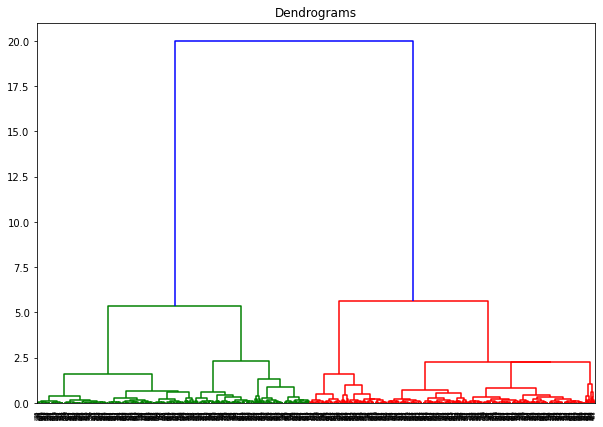

In [32]:
#generate the linkage matrix
Z = shc.linkage(data_scaled, method='ward')

# Plot a dendogram to choose number of clusters
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(Z)

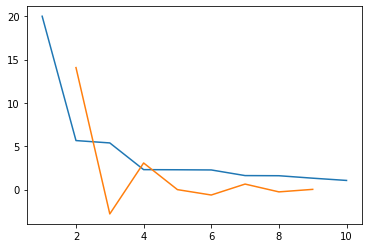

clusters: 2


In [33]:
# Define a linkage matrix and draw the elbow graph...
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# Either 2 or 4) 

#### Create categories for 2 AND 4 AND 7 Clusters

In [72]:
# Set n=2 clusters
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  # Fit the model
clusters2N = cluster.fit_predict(data_scaled) # Predict the cluster from the data and save it
features['cluster2n'] =  clusters2N  # append it to original features
data_scaled['cluster2n'] =  clusters2N  # append it to scaled features
 
# Set n=4 clusters
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  # Fit the model
clusters4N = cluster.fit_predict(data_scaled) # Predict the cluster from the data and save it
features['cluster4n'] =  clusters4N 
data_scaled['cluster4n'] =  clusters4N 

# Set n=7 clusters
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  # Fit the model
clusters7N = cluster.fit_predict(data_scaled) # Predict the cluster from the data and save it
features['cluster7n'] =  clusters7N 
data_scaled['cluster7n'] =  clusters7N 

# Re-attach geo names and numbers
df_clst_scaled = pd.concat([names, data_scaled], axis=1) 
df_clst_orginal = pd.concat([names, features], axis=1)

df_clst_orginal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 901
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GEO              902 non-null    object 
 1   geo_code         902 non-null    int64  
 2   rmt_indx         902 non-null    float64
 3   pop_tot          902 non-null    float64
 4   pop_density      902 non-null    float64
 5   pop_change       902 non-null    float64
 6   pop_medAge       902 non-null    float64
 7   school_none      902 non-null    float64
 8   school_uni       902 non-null    float64
 9   work_unempRate   902 non-null    float64
 10  work_agr         902 non-null    float64
 11  work_arts        902 non-null    float64
 12  work_biz         902 non-null    float64
 13  trnst_active     902 non-null    float64
 14  trnst_car        902 non-null    float64
 15  trnst_15minutes  902 non-null    float64
 16  bldgs_house      902 non-null    float64
 17  bldgs_aprtmnt   

#### Summarize membership of 2N, 4N and 7N

In [74]:
# What are the membership lists for the 2, 4, 7, 
# summarize four groups by average values? 

# the columns that don't seem very different (based on df_clst_orginal.groupby('cluster7n').mean().reset_index())
#... can get dropped
drop_cols = ['pop_medAge','work_arts','work_biz','trnst_car']
df_clst_orginal_2 = df_clst_orginal.drop(drop_cols, axis=1)
df_clst_orginal_2

,GEO,geo_code,rmt_indx,pop_tot,pop_density,pop_change,school_none,school_uni,work_unempRate,work_agr,trnst_active,trnst_15minutes,bldgs_house,bldgs_aprtmnt,pop_1stGenImm,lang_noEngFr,HDD_tot,CDD_tot,cluster2n,cluster4n,cluster7n
0,"Abbotsford (CY), British Columbia",5909052,0.1315,141397.0,376.5,5.9,0.155730,0.148359,6.6,0.058317,0.040196,0.353933,0.398348,0.020392,0.297210,0.235351,2680.813547,163.637931,1,3,1
1,"Aberdeen (T), Saskatchewan",4715019,0.2595,622.0,318.8,3.8,0.173913,0.097826,8.3,0.033898,0.092593,0.185185,0.934783,0.000000,0.042735,0.028226,6052.908161,137.855172,0,2,6
2,"Aberdeen No. 373 (RM), Saskatchewan",4715018,0.2154,1379.0,2.0,35.7,0.091549,0.199531,2.6,0.058065,0.000000,0.045802,0.978495,0.000000,0.031802,0.039855,6052.908161,137.855172,0,2,5
3,"Addington (P), New Brunswick",1314012,0.3872,656.0,0.7,-8.5,0.305085,0.059322,28.1,0.032258,0.000000,0.244444,0.935484,0.000000,0.037879,0.000000,5392.582414,171.500000,0,2,6
4,"Adelaide-Metcalfe (TP), Ontario",3539047,0.1197,2990.0,9.0,-1.3,0.149007,0.119205,3.8,0.085294,0.061594,0.386282,0.984848,0.000000,0.131119,0.068258,3888.683333,403.960000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,"Wôlinak (IRI), Quebec",2438802,0.1285,202.0,270.1,12.2,0.241935,0.000000,0.0,0.117647,0.000000,0.562500,0.666667,0.000000,0.048780,0.012195,4804.370912,334.756667,0,2,6
898,"Yakweakwioose 12 (IRI), British Columbia",5909831,0.1530,44.0,212.2,12.8,0.285714,0.142857,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2617.854433,219.510714,0,2,6
899,"Yamachiche (MÉ), Quebec",2451020,0.1155,2830.0,26.6,1.5,0.262582,0.076586,5.9,0.031690,0.044177,0.373494,0.735294,0.000000,0.003584,0.004867,4726.548480,297.441379,1,1,0
900,"Yellowknife (CY), Northwest Territories",6106023,0.3995,19569.0,185.5,1.7,0.109091,0.277110,5.9,0.023487,0.223861,0.671584,0.449509,0.053296,0.165673,0.107668,8154.377011,23.334483,0,0,4


##### 7N

In [82]:
# members of clusters
df_clst_orginal_2.query('cluster7n == 1').GEO.sample(15)

249                           Gatineau (V), Quebec
849                  Vernon (CY), British Columbia
393                         Loyalist (TP), Ontario
164                         Cornwall (CY), Ontario
560                      Pointe-Claire (V), Quebec
0                Abbotsford (CY), British Columbia
456    Mount Pearl (CY), Newfoundland and Labrador
488                   Norfolk County (CY), Ontario
703                   Sainte-Catherine (V), Quebec
883                         Whitehorse (CY), Yukon
766     St. John's (CY), Newfoundland and Labrador
97                             Candiac (V), Quebec
608                  Riverview (TV), New Brunswick
440                      Mississauga (CY), Ontario
650                     Saint-Eustache (V), Quebec
Name: GEO, dtype: object

In [56]:
df_clst_orginal_2.groupby('cluster7n').mean().reset_index().drop('geo_code', axis=1)

,cluster7n,rmt_indx,pop_tot,pop_density,pop_change,school_none,school_uni,work_unempRate,work_agr,trnst_active,trnst_15minutes,bldgs_house,bldgs_aprtmnt,pop_1stGenImm,lang_noEngFr,HDD_tot,CDD_tot,cluster2n,cluster4n
0,0,0.230483,3104.309524,143.100000,3.840476,0.138570,0.130908,7.949206,0.035043,0.033736,0.294074,0.812384,0.000446,0.066341,0.034951,4513.628623,218.309082,0.0,1.0
1,1,0.148990,105043.796078,830.640000,5.839216,0.117598,0.189181,6.828235,0.020272,0.060576,0.337433,0.592756,0.047685,0.167924,0.094458,4187.172860,293.329003,1.0,3.0
2,2,0.199676,6469.397727,397.592045,6.512500,0.127065,0.158107,6.586364,0.033336,0.038039,0.284549,0.779671,0.010718,0.088938,0.046637,4522.925818,245.006201,0.0,0.0
3,3,0.199080,468.466667,1542.633333,9.093333,0.220523,0.072352,13.153333,0.015134,0.186689,0.365891,0.491368,0.061424,0.070107,0.041986,3018.913381,163.990406,0.0,2.0
4,4,0.213252,12219.295918,447.695918,5.241837,0.138490,0.145176,7.405102,0.032745,0.058684,0.441802,0.690945,0.005418,0.097038,0.051940,4802.765139,234.249033,0.0,0.0
5,5,0.275381,1463.744186,137.646512,5.747287,0.168146,0.105173,10.259690,0.049450,0.042007,0.287486,0.857207,0.001643,0.042736,0.040137,5149.691717,161.031325,0.0,2.0
6,6,0.293653,465.633508,114.126178,3.497382,0.194005,0.091000,12.843455,0.069367,0.056078,0.311131,0.878402,0.000226,0.048226,0.036614,4985.593578,151.318012,0.0,2.0


#### Cluster Figures

In [75]:
shapes = df_weather.set_geometry('geometry_CSD')


gdf_cluster_original_3 = shapes.merge(df_clst_orginal_2, left_on='CSDUID', right_on='geo_code', how='right').set_geometry('geometry_CSD')

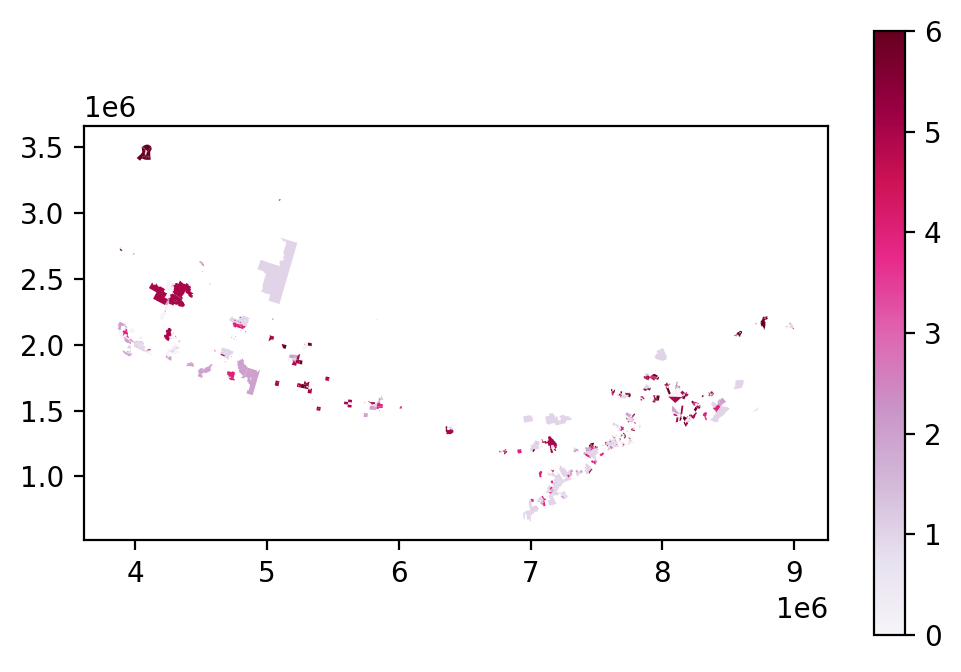

In [76]:
# Show them on a map.
#Plot choropleth
fig, ax = plt.subplots(dpi=200)
gdf_cluster_original_3.plot(ax=ax, column='cluster7n', cmap='PuRd',legend=True)

In [77]:
fig = px.scatter(df_clst_scaled, x='pop_change', y='CDD_tot', color='cluster4n',
                 size='pop_tot', hover_data=['GEO'])
fig.show()

In [81]:
fig = px.scatter(df_clst_scaled, x='school_uni', y='trnst_active', color='cluster7n',
                 size='pop_tot', hover_data=['GEO'])
fig.show()

In [39]:
fig = px.scatter(df_clst_scaled, x='pop_density', y='rmt_indx', color='cluster4n',
                 size='pop_medAge', hover_data=['GEO'])
fig.show()

In [44]:
fig = px.scatter(df_clst_scaled, x='pop_density', y='rmt_indx', color='cluster2n',
                 size='pop_medAge', hover_data=['GEO'])
fig.show()

## PLOTS and MAPS


In [ ]:
# Heatmap of correlations 
# Later revisit this and improve: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr = df_census_3.corr()
plt.subplots(figsize=(20,15))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)



ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# check for place & feature combination where counts female and counts male are very different
df_census_3b = df_census_1.copy()
df_census_3b['prct_diff_female2male']= ((df_census_3b['count_female']-df_census_3b['count_male'])/df_census_3b['count_all']).replace([np.inf, -np.inf], np.nan)

 # look at place & feature combinations with biggest discrepancy:
df_census_3b.sort_values(by=['prct_diff_female2male']).head(50) 

# grab median income difference as a percentage of local median
prct_diff_female2male = df_census_3b[df_census_3b['feature']=='Median total income in 2015 among recipients ($)'][['geo_code','prct_diff_female2male']] 

# visualize in plotly; cartographically 
prct_diff_female2male

df_forplotting = df_geo.merge(prct_diff_female2male,
                              left_on='geo_code',
                              right_on='geo_code')

# df_census_3b.sort_values(by=['prct_diff_female2male']).head(50)


In [ ]:
#plot merged file. use dropna to remove any country with no revenue value
ax = df_forplotting.dropna().plot(column='prct_diff_female2male', cmap =    
                                'YlGnBu', alpha=1.0, figsize=(30,13), k=3, legend =  
                                  True);

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

### Population Density and Prevalance of Single Detached Houses

In [ ]:
alt.Chart(df_census_3).mark_point().encode(
    x='trnsprt_commuteByCar',
    y='bldgs_LiveInHouses',
    color='pop_density',
).interactive().properties(
    width=800,
    height=500
)

alt.Chart(...)

In [ ]:
fig = px.scatter(df_census_3, x="trnsprt_commuteByCar", y="bldgs_LiveInHouses", color="pop_density",
                 size='age_median', hover_data=['geo_name'])
fig.show()

### Percentage population working in the arts versus percentage who commute by active transportation

In [ ]:
alt.Chart(df_census_3).mark_point().encode(
    x='trnsprt_commuteByCar',
    y='bldgs_LiveInHouses',
    color='pop_density',
).interactive().properties(
    width=800,
    height=500
)

#### With final merged dataframe, add the means as a row

In [ ]:
# add row of means
avg = df_census_1a.mean() 
df_census_2 = df_census_1a.append(avg, ignore_index= True)
df_census_2.geo_name[df_census_2.geo_name.isnull()] = 'All_CSDs_AVG'

## Setup Comparison Global Municipalities...